Diseases classification model with decision trees - in this model I will use clusters as classification labels. Clusterss were created with k-means analysis.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Load dataset
scaled_df = pd.read_csv('../Data/scaled_df.csv')

In [3]:
# Checking prepered dataset
scaled_df.head()

,Age,Gender,Sickness_Duration_Months,RBC_Count,Hemoglobin,Hematocrit,MCV,MCH,MCHC,RDW,Reticulocyte_Count,WBC_Count,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,PLT_Count,MPV,ANA,Esbach,MBL_Level,ESR,C3,C4,CRP,Anti-dsDNA,Anti-Sm,Rheumatoid factor,ACPA,Anti-TPO,Anti-Tg,Anti-SMA,Low-grade fever,Fatigue or chronic tiredness,Dizziness,Weight loss,Rashes and skin lesions,Stiffness in the joints,Brittle hair or hair loss,Dry eyes and/or mouth,General unwell feeling,Joint pain,Anti_dsDNA,Anti_enterocyte_antibodies,ASCA,Anti_BP180,ASMA,IgG_IgE_receptor,Anti_SRP,Anti_La_SSB,Anti_Jo1,Anti_desmoglein_1,EMA,Anti_type_VII_collagen,C1_inhibitor,Anti_epidermal_basement_membrane_IgA,Anti_OmpC,pANCA,Anti_tissue_transglutaminase,anti_Scl_70,Anti_Mi2,Anti_parietal_cell,Progesterone_antibodies,Anti_Sm,Diseases_ID,Diseases_eng,Diseases_group
0,0.712121,1,0.218487,0.016667,0.424000,0.596429,0.828276,0.966667,0.424,0.226667,0.632,0.534817,0.938889,0.160000,0.90750,0.7550,0.58,0.822857,0.216,1,0.482759,0.894444,0.816327,0.836364,0.78,0.310,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,Linear IgA disease,7
1,0.651515,0,0.890756,0.612500,0.630667,0.456429,0.661887,0.656667,0.014,0.811111,0.284,0.574072,0.594000,0.922667,0.08250,0.1675,0.66,0.968049,0.384,1,0.572414,0.488889,0.469388,0.000000,0.14,0.273,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,Dermatomyositis,4
2,0.363636,0,0.050420,0.170833,0.488000,0.457857,0.441814,0.571667,0.922,0.893333,0.872,0.589949,0.464889,0.540333,0.62000,0.8300,0.57,1.000000,0.140,1,0.824138,0.677778,0.897959,0.500000,0.32,0.102,1,0,1,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ord's thyroiditis,8
3,0.409091,1,0.092437,0.445833,0.661333,0.292857,0.364788,0.236667,0.586,0.142222,0.516,0.462308,0.248889,0.620000,0.56750,0.5300,0.22,0.074418,0.790,1,0.224138,0.472222,0.510204,0.600000,0.32,0.545,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,Restless legs syndrome,5
4,0.909091,1,0.252101,0.575000,0.161333,0.112857,0.605202,0.645000,0.058,0.922222,0.368,0.719465,0.351556,0.919000,0.13125,0.9000,0.90,0.918556,0.702,1,0.227586,0.522222,0.857143,0.300000,0.30,0.105,0,1,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,Autoimmune polyendocrine syndrome type 2 (APS2),8


In [4]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12499 entries, 0 to 12498
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   12499 non-null  float64
 1   Gender                                12499 non-null  int64  
 2   Sickness_Duration_Months              12499 non-null  float64
 3   RBC_Count                             12499 non-null  float64
 4   Hemoglobin                            12499 non-null  float64
 5   Hematocrit                            12499 non-null  float64
 6   MCV                                   12499 non-null  float64
 7   MCH                                   12499 non-null  float64
 8   MCHC                                  12499 non-null  float64
 9   RDW                                   12499 non-null  float64
 10  Reticulocyte_Count                    12499 non-null  float64
 11  WBC_Count      

In [5]:
# Checking the number of cases in each diseases group
scaled_df['Diseases_group'].value_counts()

Diseases_group
6    2499
5    2206
7    1649
9    1332
8    1222
3    1171
4     752
1     677
2     506
0     485
Name: count, dtype: int64

Training the base model with the full set of features. That allows me for assessing the model's baseline potential

In [6]:
# Preparing features and labels DataFrames
X = scaled_df.drop(columns=['Diseases_group', 'Diseases_ID', 'Diseases_eng'])
y = scaled_df['Diseases_group']

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [10]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [11]:
print("Best parameters:", random_search.best_params_)
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.87      0.73        95
           1       0.31      0.41      0.36       150
           2       0.06      0.08      0.07       110
           3       0.13      0.12      0.13       217
           4       0.18      0.20      0.19       169
           5       0.23      0.16      0.19       434
           6       1.00      1.00      1.00       494
           7       0.59      0.60      0.59       320
           8       0.13      0.13      0.13       253
           9       0.14      0.14      0.14       258

    accuracy                           0.42      2500
   macro avg       0.34      0.37      0.35      2500
weighted avg       0.41      0.42      0.41      2500

Confusion matrix:
[[ 83   1   0   1   3   2   0   2   1   2]
 [  4  62   5   6  12  21   0   8  19  13]
 [  2   8   9  13  14  24   0 

The results of the base model are slighty worese then the results of the model with clusters as labels

As in classification model with clusters as labels, the next step will be features optimization to find the best subset using RFE technique

In [14]:
# Searching for optimal number of features
metrics_results = []

for n_features in range(5, X_train.shape[1] + 1, 5): 
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=n_features)
    rfe.fit(X_train_res, y_train_res)
    
    X_train_rfe = rfe.transform(X_train_res)
    X_test_rfe = rfe.transform(X_test)
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_rfe, y_train_res)
    
    y_pred = model.predict(X_test_rfe)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    
    metrics_results.append({'n_features': n_features, 'accuracy': acc, 'precision': prec, 'recall': rec})

metrics_df = pd.DataFrame(metrics_results)

optimal_n_features = metrics_df.loc[metrics_df['accuracy'].idxmax(), 'n_features']
print(f"Optimal number of features: {optimal_n_features}")


Optimal number of features: 55


In [15]:
# Tuning RFE with the optimal number of features
rfe_optimal = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=optimal_n_features)
rfe_optimal.fit(X_train_res, y_train_res)

RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=55)

In [16]:
# Feature ranking and most important feature selection
feature_ranking = pd.DataFrame({
    'feature': X_train.columns, 
    'ranking': rfe_optimal.ranking_,
    'support': rfe_optimal.support_
}).sort_values(by='ranking')

selected_features = feature_ranking[feature_ranking['support']].copy()

The optimal number of features is 55 and with this subset cross-validate can be conducted to check it's stability and generalization.

In [17]:
# Cross validation of the final model
X_train_rfe_optimal = rfe_optimal.transform(X_train_res)
X_test_rfe_optimal = rfe_optimal.transform(X_test)

final_model = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(final_model, X_train_rfe_optimal, y_train_res, cv=5, scoring='accuracy')

final_model.fit(X_train_rfe_optimal, y_train_res)

y_pred_final = final_model.predict(X_test_rfe_optimal)

print(f"Cross-validated Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))
print("Final Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Cross-validated Accuracy: 0.5402 (+/- 0.0124)
Final Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.87      0.69        95
           1       0.28      0.39      0.33       150
           2       0.04      0.05      0.04       110
           3       0.14      0.15      0.14       217
           4       0.25      0.25      0.25       169
           5       0.26      0.19      0.22       434
           6       1.00      1.00      1.00       494
           7       0.58      0.57      0.58       320
           8       0.15      0.15      0.15       253
           9       0.12      0.11      0.11       258

    accuracy                           0.42      2500
   macro avg       0.34      0.37      0.35      2500
weighted avg       0.41      0.42      0.41      2500

Final Confusion Matrix:
[[ 83   2   0   2   1   2   0   2   1   2]
 [  5  59   9  10  10  18   0  12  14  13]
 [  0  14   5  13   8  25   0  10  18  17]
 [  8  22  17

To provide insight into the significance of individual variables in the final model, feature importance chart can be created

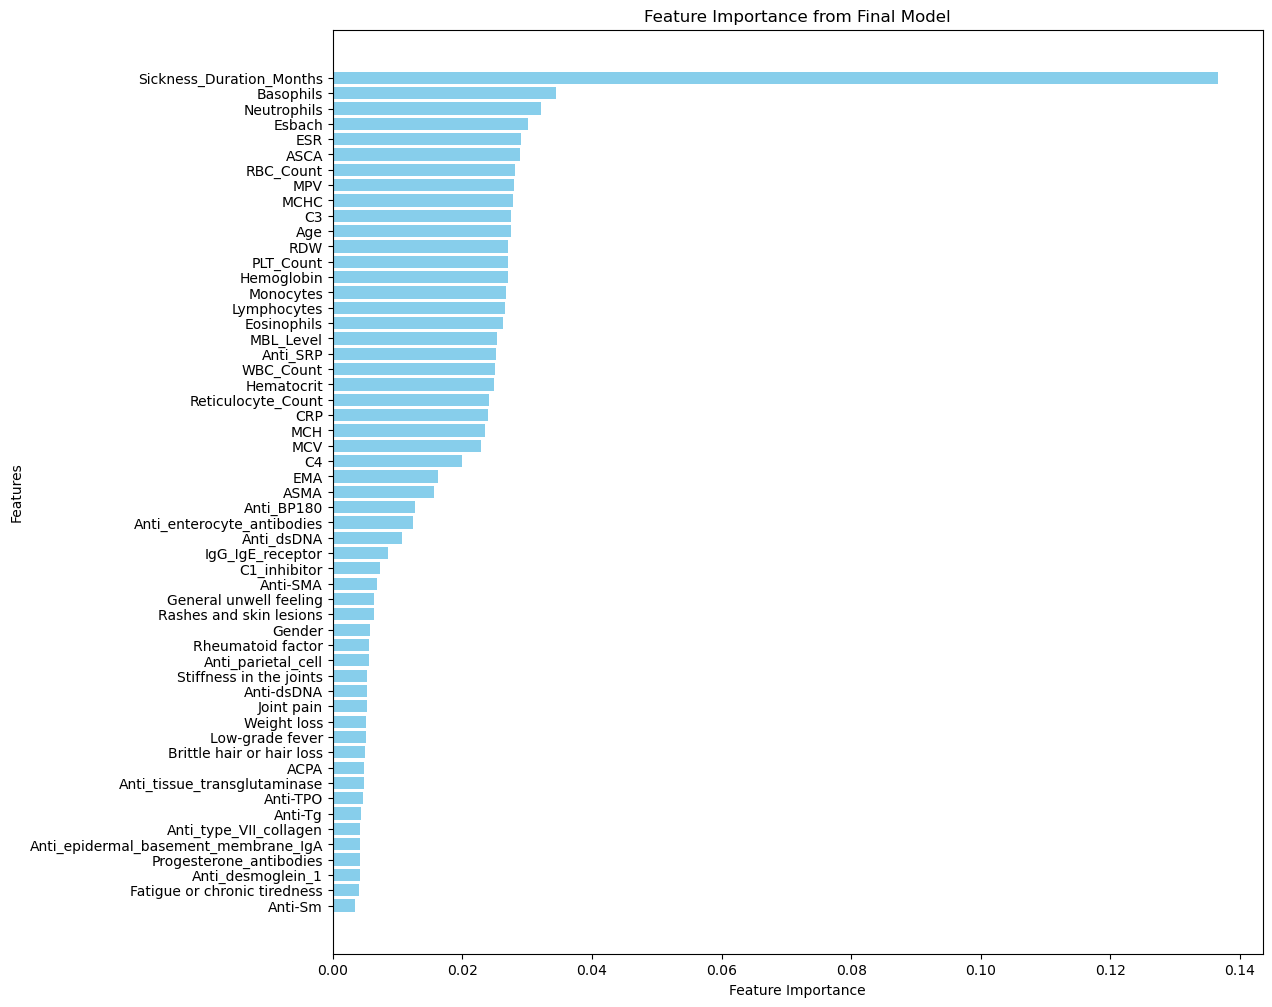

In [18]:
selected_features_names = X_train.columns[rfe_optimal.support_]

feature_importances = pd.DataFrame({
    'feature': selected_features_names,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 12))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Final Model')
plt.gca().invert_yaxis()
plt.show()


Final Classification Model Report Analysis:
- Precision: Indicates the percentage of predictions for a given class that were correct. For most classes, precision ranges from very low values (e.g., classes 2, 3, 8, 9) to high values (class 6 – 1.00).
- Recall: Indicates the percentage of actual cases of a given class that were correctly classified. Class 6 was perfectly recognized, but other classes have low values. Especially low recall for classes 2, 3, 8, and 9 means that patients belonging to these groups may be overlooked. This is potentially risky and requires improvement of the model or creating a model without those classes.
- F1-score: It is the harmonic mean of precision and recall, providing an overall measure of classification quality for a given class. Again, the F1-score is particularly low for classes 2, 3, 8, and 9.

Overall Accuracy: The overall accuracy is 42%, which suggests that the model performs moderately, especially for minority classes.

This classification model, with categories of the grouping variable defined based on domain (medical) knowledge, was compared with a classification model where the labels of the classification variable were generated using k-means clustering. There is a small difference in accuracy, precision, and recall scores between these two models, in favor of the cluster-based model. However, it should be noted that the disease groups created through clustering may present challenges in terms of their substantive interpretation. This poses a problem in the context of the business objective for which the classification model is being built (classifying patients into different autoimmune disease groups based on symptoms and test results, as well as providing recommendations for further medical diagnosis and disease prevention).


What can be done to improve this classification model? Two main strategies were considered:

- Replacing the multiclassification model with a series of binary classification models (first binary model classes: healthy/not healthy, next binary classification for each group of diseases)

- Removing disease groups with low accuracy, precision, and recall indicators. These are the groups:
    2 - Kidney and Urinary Diseases
    3 - Miscellaneous (other) Diseases
    8 - Thyroid and Endocrine Diseases
    9 - Vascular Diseases 

As the first strategy was implemented by another team member, an attempt was made in this project to improve the quality of the classification model by removing classes with low indicator values. Of course, such an approach reduces the substantive and practical value of the model, reducing the number of predicted disease groups to 6."
    

In [5]:
# Removing disease groups with low accuracy, precision, and recall indicators

categoris_to_remove = [2,3,8,9]

scaled_df_filtred = scaled_df[~scaled_df['Diseases_group'].isin(categoris_to_remove)].copy()

print(scaled_df_filtred['Diseases_group'].value_counts())

Diseases_group
6    2499
5    2206
7    1649
4     752
1     677
0     485
Name: count, dtype: int64


In [6]:
scaled_df_filtred.shape

(8268, 68)

In [7]:
X = scaled_df_filtred.drop(columns=['Diseases_group', 'Diseases_ID', 'Diseases_eng'])
y = scaled_df_filtred['Diseases_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4]

}

model = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train_res, y_train_res)

best_model_2 = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", random_search.best_params_)
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.85      0.69        88
           1       0.41      0.54      0.47       142
           4       0.29      0.38      0.33       141
           5       0.59      0.41      0.48       466
           6       1.00      1.00      1.00       524
           7       0.61      0.64      0.62       293

    accuracy                           0.67      1654
   macro avg       0.58      0.64      0.60      1654
weighted avg       0.68      0.67      0.67      1654

Confusion matrix:
[[ 75   1   2   3   0   7]
 [  5  77  12  33   0  15]
 [ 10  21  54  40   0  16]
 [ 27  72  97 189   0  81]
 [  0   0   0   0 524   0]
 [ 11  17  23  55   0 187]]


In [13]:
final_model_2 = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(final_model_2, X_train_res, y_train_res, cv=5, scoring='accuracy')

final_model_2.fit(X_train_res, y_train_res)

y_pred_final = final_model_2.predict(X_test)

print(f"Cross-validated Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))
print("Final Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Cross-validated Accuracy: 0.6944 (+/- 0.0195)
Final Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.85      0.69        88
           1       0.41      0.54      0.47       142
           4       0.29      0.38      0.33       141
           5       0.59      0.41      0.48       466
           6       1.00      1.00      1.00       524
           7       0.61      0.64      0.62       293

    accuracy                           0.67      1654
   macro avg       0.58      0.64      0.60      1654
weighted avg       0.68      0.67      0.67      1654

Final Confusion Matrix:
[[ 75   1   2   3   0   7]
 [  5  77  12  33   0  15]
 [ 10  21  54  40   0  16]
 [ 27  72  97 189   0  81]
 [  0   0   0   0 524   0]
 [ 11  17  23  55   0 187]]


As we can see above classification model with 6 class labels is better then the previous one. Global accuracy is 0.67, precision 0.58 and recall 0.64. However those indicators still aren't at high level and the utility of model with only 6 diseases categories is lower - we can't predict kidney, urinary, thyroid and vascular diseases. 